In [35]:
import os
import numpy as np
import pandas as pd
import math
import matplotlib.patches as patches
import matplotlib.pylab as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn import metrics
from sklearn import datasets
from IPython.display import Image
import seaborn as sb
from fuzzywuzzy import fuzz
import difflib
import re
import jellyfish
%matplotlib inline

The goal is to predict the operating condition of a waterpoint for each record in the dataset. We are provided the following set of information about the waterpoints:

* amount_tsh - Total static head (amount water available to waterpoint)
* ~~date_recorded - The date the row was entered~~
* funder - Who funded the well
* gps_height - Altitude of the well
* installer - Organization that installed the well
* longitude - GPS coordinate
* latitude - GPS coordinate
* ~~wpt_name - Name of the waterpoint if there is one~~
* ~~num_private~~ wtf is this?
* basin - Geographic water basin
* subvillage - Geographic location
* region - Geographic location
* region_code - Geographic location (coded)
* district_code - Geographic location (coded)
* lga - Geographic location
* ward - Geographic location
* population - Population around the well
* public_meeting - True/False
* ~~recorded_by - Group entering this row of data~~
* scheme_management - Who operates the waterpoint
* scheme_name - Who operates the waterpoint
* permit - If the waterpoint is permitted
* construction_year - Year the waterpoint was constructed
* extraction_type - The kind of extraction the waterpoint uses
* extraction_type_group - The kind of extraction the waterpoint uses
* extraction_type_class - The kind of extraction the waterpoint uses
* management - How the waterpoint is managed
* management_group - How the waterpoint is managed
* payment - What the water costs
* payment_type - What the water costs
* water_quality - The quality of the water
* quality_group - The quality of the water
* quantity - The quantity of water
* quantity_group - The quantity of water
* source - The source of the water
* source_type - The source of the water
* source_class - The source of the water
* waterpoint_type - The kind of waterpoint
* waterpoint_type_group - The kind of waterpoint

In [2]:
# Since we are dealing with a lot of columns, let's force pandas to display all of them
pd.set_option('display.max_columns', None)

In [139]:
trainValues = pd.read_csv('train_values.csv', parse_dates = True)
trainLabels = pd.read_csv('train_labels.csv')

In [215]:
# Predefine functions
# Function to draw trees
def Decision_Tree_Image(decision_tree, feature_names, name = "temp"):
    # Export decision tree to graphviz format
    dot_file = tree.export_graphviz(decision_tree.tree_, out_file = 'images/' + name + '.dot', feature_names = feature_names)
    
    # Call graphviz to make an image file from tree
    os.system("dot -T png images/" + name + ".dot -o images/" + name + ".png")
    
    # Return the png image
    return Image(filename = "images/" + name + ".png")

# Function to draw 2D scatterplots
def Plot_Data(data, var1, var2, targetVar):
    # Make the plot square
    plt.rcParams['figure.figsize'] = [12.0, 8.0]
    
    # Pretty colors for dots
    color = ['red' if x == 'non functional' else 'blue' if x == 'functional' else 'green' for x in data[targetVar]]
    
    # Plot and label
    plt.scatter(data[var1], data[var2], c = color, s = 50)
    plt.xlabel(var1)
    plt.ylabel(var2)

In [140]:
# Merge along id
train = pd.merge(trainValues, trainLabels, on='id')

## Data cleaning and manipulation

Time variables

In [160]:
def timecleaner(df):
    df.construction_year=pd.to_numeric(df.construction_year)
    df.loc[df.construction_year <= 0, df.columns=='construction_year'] = 1950 #mattiaf does this but I am not sure whether we should set 0-s to 1950
    df.date_recorded = df.date_recorded.apply(pd.to_datetime)
    #still have to fix this
    
    timestamp1 = "Jan 1 01:01:01 2005" #there are 9 observations recorded in 2004, it is probably a mistake since all the other observations are dated between 2011 and 2013
    #I'll recode them to 2014
    t1 = datetime.strptime(timestamp1, "%b %d %H:%M:%S %Y") #this is the timestamp for comparison
    
    df['date_recorded'] = df.date_recorded.apply(lambda x: x.replace(year = x.year + 10) if x < t1 else x)
    
    #create the variable operation_time (idea taken from mattiaf), which is construction year subtracted from date_recorded in days
    df['operation_time'] = df.date_recorded - df.construction_year.apply(lambda x: pd.to_datetime(x, format = '%Y'))
    df['operation_time'] = df.operation_time.apply(lambda x: (x / np.timedelta64(1, 'D')).astype(int))
    #df.loc[df['operation_time'] < 0, df.columns=='operation_time'] = 63.92060232717317

    df['month']=pd.to_datetime(df.date_recorded).dt.month #not sure whether we should keep this
    return df

String matching for variables 'funder' and 'installer'

In [161]:
def cleaner(variable, varstring):
    checklist = ['0', 'None', 'Not Known', 'no scheme', 'Unknown']
    for i in checklist:
        train.loc[variable == i, train.columns == varstring] = 'Other'
        train.loc[variable != variable, train.columns == varstring] = 'Other'
    return train

In [162]:
train = cleaner(train.funder, 'funder')
train = cleaner(train.installer, 'installer')
train = cleaner(train.scheme_management, 'scheme_management')
train = cleaner(train.scheme_name, 'scheme_name')

In [163]:
def process_str_for_similarity_cmp(input_str, normalized=False, ignore_list=[]):
    """ Processes string for similarity comparisons , cleans special characters and extra whitespaces
        if normalized is True and removes the substrings which are in ignore_list)
    Args:
        input_str (str) : input string to be processed
        normalized (bool) : if True , method removes special characters and extra whitespace from string,
                            and converts to lowercase
        ignore_list (list) : the substrings which need to be removed from the input string
    Returns:
       str : returns processed string
    """ #this piece of code is from http://stackoverflow.com/questions/38969383/fuzzy-string-matching-in-python
    for ignore_str in ignore_list:
        input_str = re.sub(r'{0}'.format(ignore_str), "", input_str, flags=re.IGNORECASE)

    if normalized is True:
        input_str = input_str.strip().lower()
        #clean special chars and extra whitespace
        input_str = re.sub("\W", "", input_str).strip()

    return input_str

In [164]:
funderfuzzy = list(train.funder.unique())
installerfuzzy = list(train.installer.unique())
schemefuzzy = list(train.scheme_name.unique())

def strmatcher(uniquenames): #this function creates groups from similar names (the threshold is 0.8 here)
    possiblelist = uniquenames
    matches = []
    for i in possiblelist:
        str_i = process_str_for_similarity_cmp(i) #string processing to normalize it (lowercase, no whitespaces and so on)
        imatches = [i]
        possiblelist.remove(i)
        for j in possiblelist:
            str_j = process_str_for_similarity_cmp(j)
            #match ratio is the average of the outputs of difflib's SequenceMatcher and Jellyfish's Jaro Winkler algorithm
            match_ratio = (difflib.SequenceMatcher(None, process_str_for_similarity_cmp(i), process_str_for_similarity_cmp(j)).ratio() + jellyfish.jaro_winkler(unicode(process_str_for_similarity_cmp(i)), unicode(process_str_for_similarity_cmp(j))))/2.0
            if match_ratio >= 0.8: 
                imatches.append(j) #imatches: similar groups for every item in possiblelist
                possiblelist.remove(j)
        matches.append(imatches)
    return matches

In [165]:
fundergroups = strmatcher(funderfuzzy) #these are the groups which are going to be matched
installergroups = strmatcher(installerfuzzy)
schemegroups = strmatcher(schemefuzzy)

In [166]:
#back to the train df

train['funder_group'] = 0 #create new column for the funder names
train['installer_group'] = 0 #create new column for the installer names
train['scheme_name_group'] = 0 #create new column for the scheme names

In [167]:
#this function runs for ages!!!!!!

def backtodf(varname, newvarname, group): #the function stores the grouped names in the newly created columns
    for index, row in train.iterrows():
        searchfor = train.loc[index][varname]
        for sublist in group:
            for item in sublist:
                if item == searchfor:
                    train.ix[index, newvarname] = sublist[0] #the first element of the sublist is going to be the name of the funder
    return train

In [168]:
train = backtodf('funder','funder_group', fundergroups)
train = backtodf('installer','installer_group', installergroups)

In [169]:
train = backtodf('scheme_name','scheme_name_group', schemegroups)

In [170]:
train.funder_group[train.funder_group == 0] = train.funder #if no similar value, funder_group gets the same value as funder
train.installer_group[train.installer_group == 0] = train.installer #same for installer
train.scheme_name_group[train.scheme_name_group == 0] = train.scheme_name #same for scheme name

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [171]:
funders = train.groupby('funder_group').count() #grouping by funder name
smallfunders = funders[funders['id'] < 10]
smallfunders = list(smallfunders.index.values) #list of funders with less than 10 occurrence

installers = train.groupby('installer_group').count() #grouping by installer name
smallinst = installers[installers['id'] < 10]
smallinst = list(smallinst.index.values) #list of installers with less than 10 occurrence

schemes = train.groupby('scheme_name_group').count() #grouping by scheme name
smallscheme = schemes[schemes['id'] < 10]
smallscheme = list(smallscheme.index.values) #list of scheme names with less than 10 occurrence

In [172]:
def checknames(x, smallnames): #changes the names of the small funders or installers to 'Other'
    if x in smallnames:
        return 'Other'
    else:
        return x

In [173]:
train['funder_group'] = train['funder_group'].apply(checknames, args=(smallfunders,))
train['installer_group'] = train['installer_group'].apply(checknames, args=(smallinst,))
train['scheme_name_group'] = train['scheme_name_group'].apply(checknames, args=(smallscheme,))

### Data Exploration

In [216]:
train.head(n = 100)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,funder_group,installer_group,scheme_name_group
0,69572.0,61,2011-03-14,1030,1390.0,1145,34.938093,-9.856322,24849,0,2,7590,3,9,4,33,900,108,202,1,7,1613,0,1999.0,4,2,1,8,5,3,1,7,3,2,2,9,7,1,2,2,1,224,222,376
1,8776.0,0,2013-03-06,351,1399.0,399,34.698766,-2.147466,24712,0,5,9866,8,16,1,68,1000,275,16140,1,2,1554,16974,2010.0,4,2,1,12,5,1,3,7,3,3,3,6,4,2,2,2,1,93,82,363
2,34310.0,13,2013-02-25,617,686.0,1524,37.460664,-3.821329,9877,0,6,5526,7,17,3,70,1026,246,16141,1,7,1512,16974,2009.0,4,2,1,8,5,5,6,7,3,2,2,1,2,2,3,2,1,153,300,363
3,67743.0,0,2013-01-28,1297,263.0,1385,38.486161,-11.155298,24777,0,8,5456,10,22,16,57,996,57,16141,1,7,1554,16974,1986.0,15,11,6,8,5,1,3,7,3,1,1,4,1,1,3,2,3,276,267,363
4,NaN,7113,NaN,0,NaN,0,NaN,NaN,0,2791,0,0,0,3746,5960,0,0,3495,16142,0,0,0,16975,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,9944.0,12,2011-03-13,737,0.0,279,39.172796,-4.765587,24086,0,6,7594,17,2,7,41,825,0,16143,1,7,1880,16976,2009.0,15,11,6,8,5,5,6,5,5,2,2,5,3,3,3,2,1,173,59,453
6,NaN,7118,NaN,0,NaN,0,NaN,NaN,0,2785,0,0,0,3744,5964,0,0,3507,16144,0,0,0,16977,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,NaN,7120,NaN,0,NaN,0,NaN,NaN,0,2740,0,0,0,3495,5965,0,0,3513,16144,0,0,0,16977,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,NaN,7083,NaN,0,NaN,0,NaN,NaN,0,2738,0,0,0,3051,5966,0,0,3515,16144,0,0,0,16977,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,NaN,7092,NaN,0,NaN,0,NaN,NaN,0,2736,0,0,0,2967,5968,0,0,3517,16144,0,0,0,16977,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Count missing values (Zeros count as missing for now)

In [102]:
def countNA(dataframe):
    NA = {}
    lenData = len(dataframe)
    for col in dataframe:
        zeroCount = lenData - np.count_nonzero(dataframe[col])
        nanCount = dataframe[col].isnull().sum()
        missingCount = zeroCount + nanCount
        NA['NA_{}'.format(col)] = {'count': missingCount, 'proportion': '{:.1%}'.format(float(missingCount)/float(lenData))}
    return NA
        
naCount = countNA(train)        
    

In [103]:
pd.DataFrame.from_dict(naCount, orient='index')

,count,proportion
NA_amount_tsh,41639,70.1%
NA_basin,0,0.0%
NA_construction_year,20709,34.9%
NA_date_recorded,0,0.0%
NA_district_code,23,0.0%
NA_extraction_type,0,0.0%
NA_extraction_type_class,0,0.0%
NA_extraction_type_group,0,0.0%
NA_funder,3635,6.1%
NA_gps_height,20438,34.4%


In [104]:
# Make cross table for each column against status to check for patterns
def crossTab(dataframe, refCol):
    colNames = list(dataframe.drop([refCol], 1))
    ctDict = {}
    for i in colNames:
        ctDict['crossTab_{}'.format(i)] = pd.crosstab(dataframe[i], dataframe[refCol])
    return ctDict

tables = crossTab(train, 'status_group')

In [97]:
tables['crossTab_region']

status_group,0,1,2,3
region,,,,
0,21381,0,0,0
1,0,2293,175,881
2,0,461,3,341
3,0,3201,115,814
4,0,1361,603,821
5,0,2640,322,1417
6,0,460,93,993
7,0,987,96,500
8,0,886,60,1023


* crossTab_quantity: most 'dry's are non-functional
* crossTab_funder: need cleaning
* crossTab_installer: need cleaning
* crossTab_subvillage: need cleaning, might be fubar
* crossTab_region, region_code, district_code: clean. more region codes than both region and district codes, not sure why
* crossTab_scheme_name: need cleaning
* crossTab_construction_year: lots of missing data

## Impute population

In [175]:
def impute(base, target, df):
    df[df[target] == 0] = np.nan
    df[target].fillna(df.groupby(base)[target].transform("mean"), inplace=True)

In [176]:
impute('district_code', 'population', train)

## Modeling

Convert to factors

In [217]:
from sklearn import preprocessing
factorConvert = [x for x in train.columns if x not in ['id','latitude','longitude','gps_height','date_recorded','construction_year','month','operation_time', 'population']]

for factor in factorConvert:
    train[factor] = preprocessing.LabelEncoder().fit_transform(train[factor])

In [221]:
list(train)

['id',
 'amount_tsh',
 'date_recorded',
 'funder',
 'gps_height',
 'installer',
 'longitude',
 'latitude',
 'wpt_name',
 'num_private',
 'basin',
 'subvillage',
 'region',
 'region_code',
 'district_code',
 'lga',
 'ward',
 'population',
 'public_meeting',
 'recorded_by',
 'scheme_management',
 'scheme_name',
 'permit',
 'construction_year',
 'extraction_type',
 'extraction_type_group',
 'extraction_type_class',
 'management',
 'management_group',
 'payment',
 'payment_type',
 'water_quality',
 'quality_group',
 'quantity',
 'quantity_group',
 'source',
 'source_type',
 'source_class',
 'waterpoint_type',
 'waterpoint_type_group',
 'status_group',
 'funder_group',
 'installer_group',
 'scheme_name_group']

Start tree

In [222]:
train.isnull().any()

id                        True
amount_tsh               False
date_recorded             True
funder                   False
gps_height                True
installer                False
longitude                 True
latitude                  True
wpt_name                 False
num_private              False
basin                    False
subvillage               False
region                   False
region_code              False
district_code            False
lga                      False
ward                     False
population               False
public_meeting           False
recorded_by              False
scheme_management        False
scheme_name              False
permit                   False
construction_year         True
extraction_type          False
extraction_type_group    False
extraction_type_class    False
management               False
management_group         False
payment                  False
payment_type             False
water_quality            False
quality_

In [225]:
excludeAttr = ['date_recorded', 'wpt_name', 'num_private', 'subvillage', 'region', 'longitude', 'latitude', 'gps_height',
              'recorded_by', 'extraction_type_group', 'extraction_type_class', 'status_group', 'id', 'construction_year']

In [226]:
Y = train['status_group']
X = train.drop(excludeAttr, axis = 1)

In [227]:
treeEntropy = DecisionTreeClassifier(max_depth = 12, criterion = 'entropy')
treeEntropy.fit(X, Y)
Decision_Tree_Image(treeEntropy, X.columns)
print "Accuracy score for tree is %.3f" %metrics.accuracy_score(treeEntropy.predict(X), Y)

Accuracy score for tree is 0.862


Split set

In [228]:
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, train_size = 0.80)

In [229]:
treeEntropy.fit(Xtrain, Ytrain)
print 'Accuracy score of tree on train = %.3f' %metrics.accuracy_score(treeEntropy.predict(Xtrain), Ytrain)
print 'Accuracy score of tree on test = %.3f' %metrics.accuracy_score(treeEntropy.predict(Xtest), Ytest) 

Accuracy score of tree on train = 0.863
Accuracy score of tree on test = 0.844


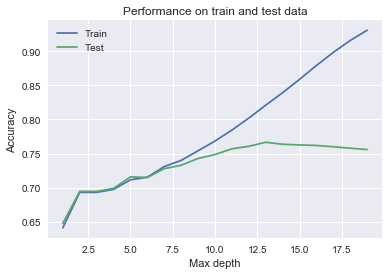

In [15]:
accuraciesTrain = []
accuraciesTest = []
depths = range(1, 20)

for md in depths:
    model = DecisionTreeClassifier(max_depth = md)
    model.fit(Xtrain, Ytrain)
    
    accuraciesTrain.append(metrics.accuracy_score(model.predict(Xtrain), Ytrain))
    accuraciesTest.append(metrics.accuracy_score(model.predict(Xtest), Ytest))

plt.plot(depths, accuraciesTrain, label = "Train")
plt.plot(depths, accuraciesTest, label = "Test")
plt.title("Performance on train and test data")
plt.xlabel("Max depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

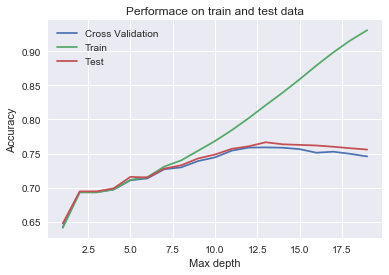

In [16]:
accuraciesCrossValidation = []
depths = range(1, 20)

for md in depths:
    model = DecisionTreeClassifier(max_depth = md)
    
    accuraciesCrossValidation.append(np.mean(cross_validation.cross_val_score(model, X, Y)))

plt.plot(depths, accuraciesCrossValidation, label = "Cross Validation")
plt.plot(depths, accuraciesTrain, label = "Train")
plt.plot(depths, accuraciesTest, label = "Test")
plt.title("Performace on train and test data")
plt.xlabel("Max depth")
plt.ylabel("Accuracy")
#plt.ylim([0.8, 1.0])
#plt.xlim([1,20])
plt.legend()
plt.show()

Quite shit. Try with random forest

Tuning the model with 100 trees, 20 min samples each leaf, no restriction on number of processors used (n_jobs).

In [230]:
from sklearn.ensemble import RandomForestClassifier
randomForest = RandomForestClassifier(max_features = 'sqrt', n_estimators = 100, min_samples_leaf = 10,
                                     max_depth = 20, n_jobs = -1, criterion = 'entropy')
randomForest.fit(Xtrain, Ytrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=20, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=10,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

Things learned from fucking with the model
* no max_depth is better
* 100 trees seem optimum. More or less would result in worse performance

In [231]:
print 'Accuracy score of random forest on train = %.3f' %metrics.accuracy_score(randomForest.predict(Xtrain), Ytrain)
print 'Accuracy score of random forest on test = %.3f' %metrics.accuracy_score(randomForest.predict(Xtest), Ytest)

Accuracy score of random forest on train = 0.892
Accuracy score of random forest on test = 0.874


Create cross table of actual and predicted

In [114]:
forestPreds = randomForest.predict(Xtest)
pd.crosstab(Ytest, forestPreds, rownames=['Actual status'], colnames=['Predicted status'])

Predicted status,0,1,2
Actual status,,,
0,5952,62,424
1,548,228,131
2,1263,32,3240


Pretty shit to predict non-functional pumps it seems. False positive is not good.

In [20]:
list(zip(Xtrain, randomForest.feature_importances_))

[('amount_tsh', 0.02830646093697493),
 ('funder', 0.031069409104459784),
 ('gps_height', 0.032309180282296054),
 ('installer', 0.027167897624541571),
 ('longitude', 0.068997487599320659),
 ('latitude', 0.059104654295842558),
 ('basin', 0.018919086123095272),
 ('region_code', 0.026945018420741661),
 ('lga', 0.040232443701938875),
 ('ward', 0.025652837857831873),
 ('population', 0.021308761803033684),
 ('public_meeting', 0.016972018052718137),
 ('scheme_management', 0.015176593850793833),
 ('scheme_name', 0.022534227165139531),
 ('permit', 0.020096599308994625),
 ('construction_year', 0.042218569895965313),
 ('extraction_type', 0.037887256664569956),
 ('management', 0.015890013285915112),
 ('management_group', 0.005542687695986601),
 ('payment', 0.020094829095219428),
 ('payment_type', 0.020657391987610869),
 ('water_quality', 0.0050002617055904964),
 ('quality_group', 0.0053632076270068354),
 ('quantity', 0.11857561876937954),
 ('quantity_group', 0.11240563278356078),
 ('source', 0.0245

Initiate bagging

In [232]:
from sklearn.ensemble import BaggingClassifier
bagTree = BaggingClassifier(n_estimators = 50, n_jobs = -1)
bagTree.fit(Xtrain, Ytrain)

BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=50, n_jobs=-1, oob_score=False, random_state=None,
         verbose=0, warm_start=False)

In [233]:
print 'Accuracy score of bagged tree on train = %.3f' %metrics.accuracy_score(bagTree.predict(Xtrain), Ytrain)
print 'Accuracy score of bagged tree on test = %.3f' %metrics.accuracy_score(bagTree.predict(Xtest), Ytest)

Accuracy score of bagged tree on train = 1.000
Accuracy score of bagged tree on test = 0.872


Grid search

In [234]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

In [27]:
forestParam = {
    'max_features': ['auto', 'sqrt', 'log2'],
    'n_estimators': [50, 100, 200],
    'min_samples_leaf': [10, 15, 25],
    'max_depth': [10, 15, 20],
}
forestGrid = GridSearchCV(estimator = randomForest, param_grid = forestParam, cv = 5)

In [28]:
forestGrid.fit(Xtrain, Ytrain)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=20,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_features': ['auto', 'sqrt', 'log2'], 'n_estimators': [50, 100, 200], 'max_depth': [10, 15, 20], 'min_samples_leaf': [10, 15, 25]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [29]:
print forestGrid.best_params_

{'max_features': 'sqrt', 'n_estimators': 100, 'max_depth': 20, 'min_samples_leaf': 10}


In [235]:
print cross_val_score(randomForest, X, Y)

[ 0.86621888  0.86555556  0.86484166]
